# Bag of Words Meets Bags of Popcorn

In [1]:
import numpy as np
import pandas as pd

from emo_utils import *
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import nltk
from nltk.tokenize import TweetTokenizer

### Glove

In [2]:
glove_filename = 'glove/glove.6B/glove.6B.50d.txt'
# glove_filename = 'glove/glove.6B/glove.6B.300d.txt'
# glove_filename = 'glove/glove.twitter.27B/glove.twitter.27B.50d.txt'
# glove_filename = 'glove/glove.twitter.27B/glove.twitter.27B.200d.txt'
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_filename)

word_vec_dims = word_to_vec_map['apple'].shape[0]
print('word vectors dimensions: ' + str(word_vec_dims))

word vectors dimensions: 50


In [3]:
word = "cucumber"
index = 289846

word_to_index[word]
index_to_word[index]
word_to_vec_map[word]

array([ 0.68224 , -0.31608 , -0.95201 ,  0.47108 ,  0.56571 ,  0.13151 ,
        0.22457 ,  0.094995, -1.3237  , -0.51545 , -0.39337 ,  0.88488 ,
        0.93826 ,  0.22931 ,  0.088624, -0.53908 ,  0.23396 ,  0.73245 ,
       -0.019123, -0.26552 , -0.40433 , -1.5832  ,  1.1316  ,  0.4419  ,
       -0.48218 ,  0.4828  ,  0.14938 ,  1.1245  ,  1.0159  , -0.50213 ,
        0.83831 , -0.31303 ,  0.083242,  1.7161  ,  0.15024 ,  1.0324  ,
       -1.5005  ,  0.62348 ,  0.54508 , -0.88484 ,  0.53279 , -0.085119,
        0.02141 , -0.56629 ,  1.1463  ,  0.6464  ,  0.78318 , -0.067662,
        0.22884 , -0.042453])

### Utils

In [4]:
# tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

def split_sentence(sentence):
#     preproc = pt.tokenize(sentence)
#     return tokenizer.tokenize(preproc)
    return nltk.word_tokenize(sentence)

def sentence_len(sentence):
#     preproc = pt.tokenize(sentence)
    return len(split_sentence(sentence))

### Data

In [74]:
data = pd.read_csv('kg-data/labeledTrainData.tsv', sep='\t')
# data = shuffle(data)
data = data[:100]
data.shape

(100, 3)

In [81]:
review_len = pd.Series([len(split_sentence(x)) for x in data['review']], name='length')
data['length'] = review_len

In [82]:
data.head()

,id,sentiment,review,length
0,5814_8,1,With all this stuff going down at the moment w...,497
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",190
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,436
3,3630_4,0,It must be assumed that those who praised this...,461
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,423


246

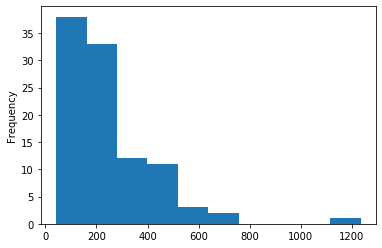

In [99]:
ax = data['length'].plot.hist()
int(data['length'].mean())

In [90]:
idx = np.random.randint(len(data))
data.iloc[idx]

id                                                      7166_2
sentiment                                                    0
review       This movie could have been very good, but come...
length                                                     128
Name: 6, dtype: object

In [11]:
X = data['review'].values
Y = data['sentiment'].values

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

In [100]:
max_len = 100
# max_len = int(np.ceil(np.mean(np.vectorize(lambda x: len(split_sentence(x)))(X_train))))
# max_len = len(split_sentence(max(X_train, key=sentence_len)))

print("max len: " + str(max_len))

max len: 100


### Model

In [29]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [15]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        j = 0
        sentence_words = split_sentence(X[i].lower())
        for w in sentence_words:
            if j >= max_len:
                break
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            j = j + 1
    return X_indices

In [16]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_vec_dims      # define dimensionality of your GloVe word vectors (= 50)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        try:
            emb_matrix[index, :] = word_to_vec_map[word]
        except:
            print("bad vector at " + str(index) + ": " + word)
            emb_matrix[index, :] = np.zeros((word_vec_dims, ))
            continue

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [101]:
def MyModel_v1(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices) 
    X = LSTM(128, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
#     X = LSTM(128, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)
#     X = Dense(128, activation='relu')(X)    
    X = Dense(1, activation='sigmoid', kernel_initializer='random_normal')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    return model

### Compile & fit

In [107]:
del model

In [108]:
model = MyModel_v1((max_len,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 128)          91648     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total para

In [109]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [110]:
es = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10, verbose=1)
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [111]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=100, \
                    callbacks=[es, mc], validation_split=0.1)

Train on 20250 samples, validate on 2250 samples
Epoch 1/100
20250/20250 [==============================] - 72s 4ms/step - loss: 0.6600 - acc: 0.6078 - val_loss: 0.6264 - val_acc: 0.6613

Epoch 00001: val_acc improved from -inf to 0.66133, saving model to model.h5
Epoch 2/100
20250/20250 [==============================] - 66s 3ms/step - loss: 0.6792 - acc: 0.5733 - val_loss: 0.6740 - val_acc: 0.6324

Epoch 00002: val_acc did not improve from 0.66133
Epoch 3/100
20250/20250 [==============================] - 66s 3ms/step - loss: 0.6170 - acc: 0.6744 - val_loss: 0.6430 - val_acc: 0.6440

Epoch 00003: val_acc did not improve from 0.66133
Epoch 4/100
20250/20250 [==============================] - 66s 3ms/step - loss: 0.5594 - acc: 0.7214 - val_loss: 0.5336 - val_acc: 0.7293

Epoch 00004: val_acc improved from 0.66133 to 0.72933, saving model to model.h5
Epoch 5/100
20250/20250 [==============================] - 66s 3ms/step - loss: 0.5100 - acc: 0.7554 - val_loss: 0.5065 - val_acc: 0.7467


KeyboardInterrupt: 

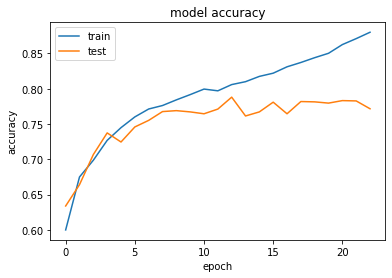

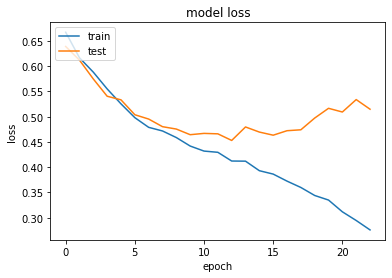

In [113]:
plot_model_accuracy(history)
plot_model_loss(history)

In [112]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
loss, acc = model.evaluate(X_test_indices, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

2500/2500 [==============================] - 3s 1ms/step
Test loss =  0.4591585941314697
Test accuracy =  0.7952


### Load model

In [105]:
del model

model = load_model('model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 50)           20000050  
_________________________________________________________________
lstm_8 (LSTM)                (None, 200, 128)          91648     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total para

### Submission

In [121]:
sub_test = pd.read_csv('kg-data/testData.tsv', sep='\t')
sub_test.shape

(25000, 2)

In [122]:
sub_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [125]:
X_sub_test = sub_test['review'].values
X_sub_test_indices = sentences_to_indices(X_sub_test, word_to_index, max_len)

25000

In [126]:
Y_sub_pred = model.predict(X_sub_test_indices).flatten()
Y_sub_pred = (Y_sub_pred > 0.5).astype(int)

In [127]:
ids = sub_test['id']
labels = pd.Series(Y_sub_pred, name="sentiment")
submission = pd.concat([ids, labels], axis=1)
submission.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [129]:
submission.to_csv('kg-data/submission.csv', sep=',', index=False)

### Kaggle

In [ ]:
!kaggle competitions download -c word2vec-nlp-tutorial -p 'kg-data'

In [130]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f 'kg-data/submission.csv' -m '<None>'

100%|█████████████████████████████████████████| 227k/227k [00:02<00:00, 102kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn